In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/Fer2013dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import numpy as np
import os
import pandas as pd

In [ ]:
IMAGE_SIZE = [224, 224,]

In [ ]:
train_dir = '/content/train'
val_dir = '/content/test'

In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# # create generator
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30,
                             validation_split=0.3
                             )
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory('/content/train', 
                                       class_mode='categorical',
                                       target_size=(224, 224),
                                       batch_size=100,
                                       subset='training',
                                       seed=7)
# prepare an iterators for each dataset
val_it = datagen.flow_from_directory('/content/test', 
                                       class_mode='categorical',
                                       target_size=(224, 224),
                                       batch_size=100,
                                       subset='validation',
                                       seed=7)

Found 20099 images belonging to 7 classes.
Found 2151 images belonging to 7 classes.


In [ ]:
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(100, 224, 224, 3), min=0.000, max=1.000


In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
output_classes = 7

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
x = Dense(500, activation='relu')(x) 
prediction = Dense(output_classes, activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
history_vgg= model.fit(
  train_it ,#‹
  validation_data=val_it,
  epochs=20
)

Epoch 1/20
201/201 [==============================] - 369s 2s/step - loss: 1.9829 - accuracy: 0.3306 - val_loss: 1.5779 - val_accuracy: 0.3747
Epoch 2/20
201/201 [==============================] - 333s 2s/step - loss: 1.5341 - accuracy: 0.4094 - val_loss: 1.4975 - val_accuracy: 0.4282
Epoch 3/20
201/201 [==============================] - 334s 2s/step - loss: 1.5120 - accuracy: 0.4147 - val_loss: 1.4748 - val_accuracy: 0.4393
Epoch 4/20
201/201 [==============================] - 333s 2s/step - loss: 1.4691 - accuracy: 0.4380 - val_loss: 1.4515 - val_accuracy: 0.4398
Epoch 5/20
201/201 [==============================] - 335s 2s/step - loss: 1.4427 - accuracy: 0.4435 - val_loss: 1.4368 - val_accuracy: 0.4556
Epoch 6/20
201/201 [==============================] - 332s 2s/step - loss: 1.4381 - accuracy: 0.4464 - val_loss: 1.4160 - val_accuracy: 0.4640
Epoch 7/20
201/201 [==============================] - 331s 2s/step - loss: 1.4122 - accuracy: 0.4574 - val_loss: 1.4061 - val_accuracy: 0.4635

In [ ]:
history_vgg.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

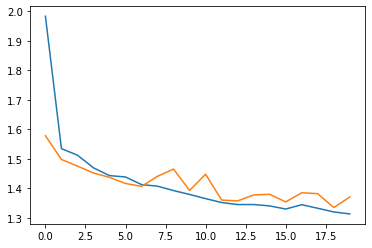

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])

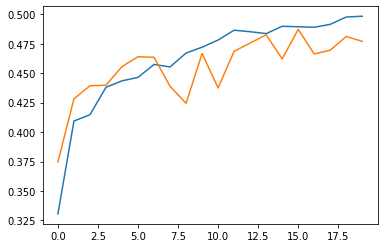

In [ ]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])

# Resnet50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
resnet = ResNet50(include_top=True,weights="imagenet",input_shape=(224,224,3),classes=1000)

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in resnet.layers[:-2]:
  layer.trainable = False

# Add Our Layers at End of Resnet50

In [ ]:
output_classes = 7

In [ ]:
# our layers - you can add more if you want
x = Flatten()(resnet.layers[-2].output)
# x = Dense(5000, activation='relu')(x)
# x = Dense(500, activation='relu')(x) 
prediction = Dense(output_classes, activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
history_resnet= model.fit(
  train_it,
  validation_data=val_it,
  epochs=5
  )

Epoch 1/5
201/201 [==============================] - 314s 2s/step - loss: 1.8185 - accuracy: 0.2450 - val_loss: 1.8088 - val_accuracy: 0.2478
Epoch 2/5
201/201 [==============================] - 302s 2s/step - loss: 1.8054 - accuracy: 0.2514 - val_loss: 1.8107 - val_accuracy: 0.2515
Epoch 3/5
201/201 [==============================] - 302s 2s/step - loss: 1.8006 - accuracy: 0.2525 - val_loss: 1.8095 - val_accuracy: 0.2529
Epoch 4/5
201/201 [==============================] - 303s 2s/step - loss: 1.7994 - accuracy: 0.2523 - val_loss: 1.7891 - val_accuracy: 0.2669
Epoch 5/5
201/201 [==============================] - 304s 2s/step - loss: 1.7965 - accuracy: 0.2546 - val_loss: 1.7941 - val_accuracy: 0.2548


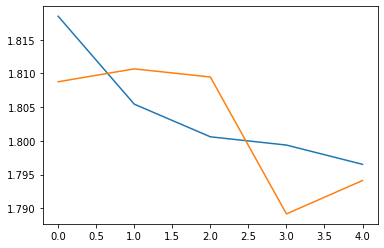

In [ ]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])

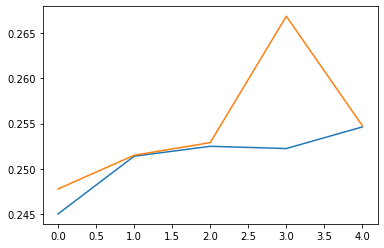

In [ ]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])